## 1. Import Libraries 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings(action='ignore', category=UserWarning)
warnings.filterwarnings('ignore')

import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

#vis 
import pyLDAvis
import pyLDAvis.gensim_models

## 1.1 nltk: Download additional subpackages

In [2]:
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Ekin\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Ekin\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Ekin\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\Ekin\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

## 2. Load the "imdb_labelled" data

In [3]:
imdb_df = pd.read_csv("imdb_labelled.txt", sep=".\t", header=None, names=['review','label'])
imdb_df

,review,label
0,"A very, very, very slow-moving, aimless movie ...",0
1,Not sure who was more lost - the flat characte...,0
2,Attempting artiness with black & white and cle...,0
3,Very little music or anything to speak of.,0
4,The best scene in the movie was when Gerardo i...,1
...,...,...
995,I just got bored watching Jessice Lange take h...,0
996,"Unfortunately, any virtue in this film's produ...",0
997,"In a word, it is embarrassing.",0
998,Exceptionally bad!,0


In [4]:
# Convert dataframe to list
review = imdb_df.review.tolist()
review[:10]

['A very, very, very slow-moving, aimless movie about a distressed, drifting young man. ',
 'Not sure who was more lost - the flat characters or the audience, nearly half of whom walked out. ',
 'Attempting artiness with black & white and clever camera angles, the movie disappointed - became even more ridiculous - as the acting was poor and the plot and lines almost non-existent. ',
 'Very little music or anything to speak of. ',
 'The best scene in the movie was when Gerardo is trying to find a song that keeps running through his head. ',
 "The rest of the movie lacks art, charm, meaning... If it's about emptiness, it works I guess because it's empty. ",
 'Wasted two hours. ',
 'Saw the movie today and thought it was a good effort, good messages for kids. ',
 'A bit predictable. ',
 'Loved the casting of Jimmy Buffet as the science teacher. ']

## 3. Data Preprocessing

- Simplfy Penn tags for the further lemmatizations steps
- Checking the list of stopwords and adding more words which can be seen in the data very frequently.  (series,movie,movies,film,films)
- Create a function for the text preprocessing
- Clean the all text using preprocessing function
- Build a dictionary with the clean words
- Transforming the dictionary into "bag" format

Regarding data preprocessing, especially for the lemmatizations steps, first we need to identify what part-of-speech any particular word is. 
Before performing preprocessing step we need a a short simplification routine to translate from the Penn tags to Simpler tags.

Since adjectives and adverbs create so much noice we only simplfy nouns and verbs

In [5]:
# simplify Penn tags to n (NOUN), v (VERB)
def simplify(penn_tag):
    pre = penn_tag[0]
    
    if (pre == 'V'):
        return 'v'
    else:
        return 'n'

In [6]:
#Print some English Stopwords
stopwords = nltk.corpus.stopwords.words('english')
stopwords[0:20]



['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his']

In [7]:
#add the words series, movie, movies, film, films to the stopword list 
stopwords = nltk.corpus.stopwords.words('english')

#set new stopwords
newStopWords = ['series','movie', 'movies', 'film', 'films']

#add these new stopwords to the 'stopwords'
stopwords.extend(newStopWords)

In [8]:
print(stopwords)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

As it can be seen from the above, the words 'series', 'movie', 'movies', 'film', 'films' were successfully added to the stopwords list

In order to preprocess the review data, we created a function,
- to remove stopwords
- use gensim.utils.simplepreprocess to lowercases and tokenizes the words.
- to lemmatize if tokenized words are pos tags and not in stop words. The WordNetLemmatizer.lemmatize() function takes a part-of-speech tag to tell it whether we're passing a noun, verb, adjective or adverb

In [9]:
# define function preprocess(text):
# gensim provides some basic preprocessing steps
def preprocess(text, language='english'):
    stop_words = stopwords # stopwords from nltk
    toks = gensim.utils.simple_preprocess(str(text), deacc=True) # gensim
    wn = WordNetLemmatizer() # from nltk
    # return
    return [wn.lemmatize(tok, simplify(pos)) for tok, pos in nltk.pos_tag(toks) if tok not in stop_words]

In [10]:
# preprocess text from all reviews
corp = [preprocess(line, language='english') for line in review]
corp[:5]

[['slow', 'move', 'aimless', 'distressed', 'drifting', 'young', 'man'],
 ['sure', 'lost', 'flat', 'character', 'audience', 'nearly', 'half', 'walk'],
 ['attempt',
  'artiness',
  'black',
  'white',
  'clever',
  'camera',
  'angle',
  'disappoint',
  'become',
  'even',
  'ridiculous',
  'acting',
  'poor',
  'plot',
  'line',
  'almost',
  'non',
  'existent'],
 ['little', 'music', 'anything', 'speak'],
 ['best', 'scene', 'gerardo', 'try', 'find', 'song', 'keep', 'run', 'head']]

After cleaning all reviews, We need to build a dictionary and convert that dictionary to bag-of-word form before feeding that into models. Because, The LDA algorithm implementation in gensim reads the strings in a 'bag of words' format.

In [11]:
# build dictionary with gensim
dictionary = gensim.corpora.Dictionary(corp) # gensim
len(dictionary)

2545

We have a vocabulary of 2545 words after preprocessing the data.

Now, we need to convert the dictionary to bag-of-word form before putting it into models

In [12]:
# Convert into bag-of-words format
bow = [dictionary.doc2bow(line) for line in corp]
(bow[0][0:20])

[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1)]

## 4. Modelling

- Run the Unguided LDA with 3,4,5,7,10 topics to get a feeling of how many numberss of clusters would be the best for our dataset and the model.
- Choose the number of topics. (In this case we choose 5 topics)
- Get the words associated with each topic and calculate the probability for each topic in each review.
- Assign the topic for each review by selecting the topic with highest probability
- Create a frequency table to check the distribution of all topics across all review
- In order to improve the results run the guided LDA with pre-defined topics that were discovered and extracted manually from the data set.
  - Pre-defined topics => We went through the first 100-150 reviews. Manually extract possible topics and words associated with each topic 
- Create a frequency table for the guided LDA to see if there is an improvement


## 4.1 Choose the number of topics

### First, try 3 topics

In [47]:
lda_model = gensim.models.LdaModel(corpus=bow, id2word=dictionary, num_topics=3, passes=8, alpha="auto")

In [48]:
lda_model.show_topics(formatted=True, num_topics=3, num_words=20)

[(0,
  '0.014*"bad" + 0.013*"see" + 0.010*"one" + 0.010*"character" + 0.008*"well" + 0.007*"like" + 0.006*"watch" + 0.006*"give" + 0.005*"think" + 0.005*"actor" + 0.005*"work" + 0.005*"play" + 0.005*"script" + 0.005*"suck" + 0.005*"way" + 0.004*"come" + 0.004*"good" + 0.004*"even" + 0.004*"scene" + 0.004*"go"'),
 (1,
  '0.012*"good" + 0.011*"make" + 0.010*"great" + 0.009*"one" + 0.006*"excellent" + 0.005*"watch" + 0.005*"find" + 0.005*"character" + 0.005*"get" + 0.004*"people" + 0.004*"cast" + 0.004*"end" + 0.004*"would" + 0.004*"play" + 0.004*"think" + 0.004*"interesting" + 0.004*"also" + 0.003*"ever" + 0.003*"performance" + 0.003*"look"'),
 (2,
  '0.010*"time" + 0.010*"like" + 0.007*"bad" + 0.007*"really" + 0.007*"make" + 0.007*"one" + 0.006*"even" + 0.006*"love" + 0.006*"look" + 0.005*"best" + 0.005*"see" + 0.005*"recommend" + 0.005*"show" + 0.005*"waste" + 0.004*"say" + 0.004*"character" + 0.004*"good" + 0.004*"act" + 0.004*"scene" + 0.004*"plot"')]

In [49]:
# Visualize model with 5 topics
pyLDAvis.enable_notebook() #allow us to see in jupyter notebook
vis = pyLDAvis.gensim_models.prepare(lda_model, bow, dictionary)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.002055 -0.093057       1        1  36.995454
2     -0.082125  0.048253       2        1  35.703003
1      0.084180  0.044804       3        1  27.301543, topic_info=          Term       Freq      Total Category  logprob  loglift
446        bad  53.000000  53.000000  Default  30.0000  30.0000
358      great  29.000000  29.000000  Default  29.0000  29.0000
299  excellent  11.000000  11.000000  Default  28.0000  28.0000
59        good  42.000000  42.000000  Default  27.0000  27.0000
96         see  49.000000  49.000000  Default  26.0000  26.0000
..         ...        ...        ...      ...      ...      ...
233     better   4.906376  13.830426   Topic3  -5.9603   0.2619
269         go   5.235965  21.302527   Topic3  -5.8953  -0.1050
419     script   5.112430  19.839423   Topic3  -5.9192  -0.0578
499     stupid   4.628705  10.888202   Topic3  -6.0186   0.4428
445        way   4.805054  19.115397   Topic3  -5.9812  -0.0826

[232 rows x 6 columns], token_table=      Topic      Freq    Term
term                         
107       1  0.466178     act
107       2  0.524450     act
15        1  0.450494  acting
15        2  0.400439  acting
15        3  0.150165  acting
...     ...       ...     ...
280       1  0.795096   write
280       2  0.079510   write
280       3  0.159019   write
396       1  0.668703    year
396       2  0.334351    year

[323 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 3, 2])

The model with 3 topics produces a good cluster that is spreaded throughout every direction and does not overlap.

### Let's try 4 topics

In [50]:
lda_model_1 = gensim.models.LdaModel(corpus=bow, id2word=dictionary, num_topics=4, passes=8, alpha="auto")

In [51]:
lda_model_1.show_topics(formatted=True, num_topics=4, num_words=20)

[(0,
  '0.010*"time" + 0.010*"great" + 0.010*"watch" + 0.008*"see" + 0.007*"get" + 0.007*"plot" + 0.006*"real" + 0.006*"go" + 0.006*"little" + 0.005*"show" + 0.005*"waste" + 0.005*"take" + 0.005*"best" + 0.005*"worth" + 0.004*"enjoy" + 0.004*"art" + 0.004*"make" + 0.004*"worse" + 0.004*"really" + 0.004*"thing"'),
 (1,
  '0.020*"one" + 0.007*"bad" + 0.006*"end" + 0.006*"make" + 0.006*"like" + 0.006*"look" + 0.005*"love" + 0.005*"watch" + 0.005*"best" + 0.005*"everything" + 0.005*"good" + 0.005*"great" + 0.005*"scene" + 0.004*"much" + 0.004*"actor" + 0.004*"think" + 0.003*"use" + 0.003*"even" + 0.003*"story" + 0.003*"really"'),
 (2,
  '0.012*"good" + 0.012*"character" + 0.011*"see" + 0.010*"one" + 0.009*"make" + 0.008*"work" + 0.007*"like" + 0.007*"really" + 0.007*"play" + 0.007*"ever" + 0.006*"give" + 0.005*"would" + 0.005*"recommend" + 0.005*"well" + 0.005*"screen" + 0.005*"scene" + 0.005*"every" + 0.004*"also" + 0.004*"even" + 0.004*"year"'),
 (3,
  '0.022*"bad" + 0.009*"like" + 0.008

In [52]:
#Visualize model with 4 topics
pyLDAvis.enable_notebook() #allow us to see in jupyter notebook
vis_1 = pyLDAvis.gensim_models.prepare(lda_model_1, bow, dictionary)
vis_1

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2     -0.066828 -0.085657       1        1  29.837240
3      0.094091  0.012406       2        1  26.413936
1      0.034760 -0.024264       3        1  24.470115
0     -0.062022  0.097516       4        1  19.278709, topic_info=         Term       Freq      Total Category  logprob  loglift
446       bad  53.000000  53.000000  Default  30.0000  30.0000
174       one  60.000000  60.000000  Default  29.0000  29.0000
615      suck  12.000000  12.000000  Default  28.0000  28.0000
419    script  20.000000  20.000000  Default  27.0000  27.0000
59       good  44.000000  44.000000  Default  26.0000  26.0000
..        ...        ...        ...      ...      ...      ...
80       make   5.165811  45.886293   Topic4  -5.5609  -0.5379
346  dialogue   3.840797   9.988197   Topic4  -5.8572   0.6904
241      like   4.337540  45.136090   Topic4  -5.7356  -0.6962
280     write   3.843527  12.387421   Topic4  -5.8565   0.4759
78       look   3.753701  21.906762   Topic4  -5.8802  -0.1179

[290 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
1757      4  0.958121  abysmal
107       1  0.236454      act
107       2  0.354681      act
107       3  0.236454      act
107       4  0.118227      act
...     ...       ...      ...
373       2  0.747257  writing
396       1  0.604661     year
396       3  0.268738     year
396       4  0.134369     year
164       3  0.685510      yes

[447 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 4, 2, 1])

The model with 4 topics is better than 3 topics.

### Try 5 topics

In [53]:
lda_model_2 = gensim.models.LdaModel(corpus=bow, id2word=dictionary, num_topics=5, passes=8, alpha="auto")

In [54]:
lda_model_2.show_topics(formatted=True, num_topics=5, num_words=20)

[(0,
  '0.008*"end" + 0.007*"way" + 0.007*"excellent" + 0.007*"every" + 0.007*"plot" + 0.006*"much" + 0.006*"good" + 0.006*"show" + 0.005*"time" + 0.005*"like" + 0.005*"scene" + 0.005*"make" + 0.005*"many" + 0.005*"well" + 0.004*"think" + 0.004*"terrible" + 0.004*"wonderful" + 0.004*"go" + 0.004*"cast" + 0.004*"character"'),
 (1,
  '0.012*"see" + 0.012*"make" + 0.011*"character" + 0.011*"one" + 0.010*"like" + 0.008*"really" + 0.007*"get" + 0.006*"find" + 0.006*"also" + 0.005*"story" + 0.005*"great" + 0.005*"give" + 0.005*"well" + 0.005*"avoid" + 0.004*"way" + 0.004*"thing" + 0.004*"minute" + 0.004*"take" + 0.004*"play" + 0.004*"best"'),
 (2,
  '0.017*"bad" + 0.012*"one" + 0.011*"see" + 0.009*"even" + 0.008*"love" + 0.008*"watch" + 0.008*"good" + 0.007*"work" + 0.006*"like" + 0.006*"great" + 0.006*"say" + 0.005*"really" + 0.005*"go" + 0.005*"enjoy" + 0.005*"actor" + 0.005*"character" + 0.005*"want" + 0.005*"art" + 0.005*"right" + 0.005*"better"'),
 (3,
  '0.012*"one" + 0.011*"good" + 0.

In [55]:
#Visualize model with 5 topics
pyLDAvis.enable_notebook() #allow us to see in jupyter notebook
vis2 = pyLDAvis.gensim_models.prepare(lda_model_2, bow, dictionary)
vis2

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2     -0.039948 -0.104978       1        1  23.249425
3     -0.026308 -0.015458       2        1  21.759850
1     -0.084752  0.069252       3        1  20.851960
0      0.048074  0.072906       4        1  18.897882
4      0.102934 -0.021722       5        1  15.240884, topic_info=          Term       Freq      Total Category  logprob  loglift
446        bad  52.000000  52.000000  Default  30.0000  30.0000
70        love  24.000000  24.000000  Default  29.0000  29.0000
15      acting  19.000000  19.000000  Default  28.0000  28.0000
174        one  60.000000  60.000000  Default  27.0000  27.0000
299  excellent  12.000000  12.000000  Default  26.0000  26.0000
..         ...        ...        ...      ...      ...      ...
358      great   4.671906  30.976181   Topic5  -5.4263  -0.0105
59        good   4.669755  43.587983   Topic5  -5.4268  -0.3525
438        end   3.600475  17.963420   Topic5  -5.6868   0.2739
454      watch   3.513615  34.862247   Topic5  -5.7112  -0.4136
25        even   3.044283  30.440730   Topic5  -5.8546  -0.4213

[360 rows x 6 columns], token_table=      Topic      Freq         Term
term                              
1757      5  0.480121      abysmal
2040      1  0.889095  achievement
15        1  0.104191       acting
15        2  0.260477       acting
15        3  0.104191       acting
...     ...       ...          ...
228       4  0.270627        would
396       1  0.069300         year
396       2  0.207901         year
396       3  0.346501         year
396       5  0.346501         year

[597 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 4, 2, 1, 5])

The model with 5 topics also gives a decent result even better than 4. Clusters having no overlappings.

### Try 7 topics

In [56]:
lda_model_3 = gensim.models.LdaModel(corpus=bow, id2word=dictionary, num_topics=7, passes=8, alpha="auto")

In [57]:
lda_model_3.show_topics(formatted=True, num_topics=7, num_words=20)

[(0,
  '0.012*"character" + 0.011*"time" + 0.009*"well" + 0.008*"also" + 0.008*"enjoy" + 0.007*"every" + 0.007*"say" + 0.006*"good" + 0.006*"actor" + 0.006*"make" + 0.006*"man" + 0.006*"part" + 0.006*"truly" + 0.006*"great" + 0.005*"play" + 0.005*"would" + 0.005*"better" + 0.005*"story" + 0.005*"believe" + 0.004*"saw"'),
 (1,
  '0.017*"see" + 0.012*"one" + 0.011*"like" + 0.009*"best" + 0.008*"make" + 0.007*"character" + 0.006*"year" + 0.006*"even" + 0.006*"scene" + 0.006*"story" + 0.006*"look" + 0.005*"good" + 0.005*"well" + 0.005*"get" + 0.005*"time" + 0.005*"avoid" + 0.005*"worst" + 0.005*"short" + 0.004*"bad" + 0.004*"actor"'),
 (2,
  '0.012*"bad" + 0.011*"good" + 0.008*"everything" + 0.008*"plot" + 0.008*"end" + 0.007*"watch" + 0.006*"think" + 0.006*"character" + 0.006*"even" + 0.006*"go" + 0.005*"one" + 0.005*"wonderful" + 0.005*"scene" + 0.005*"act" + 0.005*"like" + 0.005*"work" + 0.004*"little" + 0.004*"make" + 0.004*"worse" + 0.004*"right"'),
 (3,
  '0.016*"bad" + 0.012*"see" +

In [58]:
# Visualize model with 7 topics
pyLDAvis.enable_notebook() #allow us to see in jupyter notebook
vis3 = pyLDAvis.gensim_models.prepare(lda_model_3, bow, dictionary)
vis3

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1     -0.015727  0.059430       1        1  19.239557
5     -0.076321  0.079336       2        1  16.235183
6      0.046032  0.025895       3        1  15.154397
2     -0.040651  0.017300       4        1  14.039293
3     -0.057799 -0.095566       5        1  13.360383
0      0.139515  0.010442       6        1  12.958740
4      0.004951 -0.096837       7        1   9.012446, topic_info=            Term       Freq      Total Category  logprob  loglift
296    recommend  14.000000  14.000000  Default  30.0000  30.0000
348       really  31.000000  31.000000  Default  29.0000  29.0000
446          bad  52.000000  52.000000  Default  28.0000  28.0000
57         waste  16.000000  16.000000  Default  27.0000  27.0000
96           see  50.000000  50.000000  Default  26.0000  26.0000
..           ...        ...        ...      ...      ...      ...
300  performance   2.023435  13.600368   Topic7  -5.7377   0.5013
63         think   2.071978  23.402216   Topic7  -5.7140  -0.0178
446          bad   2.140565  52.937178   Topic7  -5.6814  -0.8015
220         give   2.015128  19.560674   Topic7  -5.7418   0.1337
78          look   2.015057  22.200237   Topic7  -5.7419   0.0071

[502 rows x 6 columns], token_table=      Topic      Freq         Term
term                              
334       2  0.670865   absolutely
334       5  0.268346   absolutely
2040      7  0.497865  achievement
107       1  0.060009          act
107       2  0.120018          act
...     ...       ...          ...
280       6  0.159042        write
396       1  0.591626         year
396       2  0.262945         year
396       5  0.131472         year
396       7  0.065736         year

[935 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 6, 7, 3, 4, 1, 5])

The clusters starts to overlap with 7 topics. However, the directions of clusters are still good.

### Try 10 topics

In [59]:
lda_model_4 = gensim.models.LdaModel(corpus=bow, id2word=dictionary, num_topics=10, passes=8, alpha="auto", random_state=42)

In [60]:
lda_model_4.show_topics(formatted=True, num_topics=10, num_words=20)

[(0,
  '0.023*"see" + 0.012*"bad" + 0.012*"suck" + 0.009*"way" + 0.008*"one" + 0.008*"actor" + 0.008*"give" + 0.007*"like" + 0.006*"know" + 0.006*"end" + 0.006*"character" + 0.006*"watch" + 0.006*"write" + 0.006*"start" + 0.006*"enjoy" + 0.005*"year" + 0.005*"act" + 0.005*"dialogue" + 0.005*"script" + 0.005*"much"'),
 (1,
  '0.015*"great" + 0.015*"good" + 0.012*"one" + 0.011*"excellent" + 0.010*"go" + 0.009*"make" + 0.009*"plot" + 0.007*"stupid" + 0.007*"watch" + 0.006*"get" + 0.006*"end" + 0.006*"bad" + 0.006*"first" + 0.006*"song" + 0.006*"truly" + 0.006*"place" + 0.005*"simply" + 0.005*"take" + 0.005*"script" + 0.005*"would"'),
 (2,
  '0.017*"like" + 0.011*"time" + 0.011*"really" + 0.010*"bad" + 0.010*"best" + 0.009*"make" + 0.008*"even" + 0.007*"would" + 0.006*"look" + 0.005*"direct" + 0.005*"part" + 0.005*"year" + 0.005*"horrible" + 0.005*"effect" + 0.005*"camera" + 0.004*"want" + 0.004*"one" + 0.004*"great" + 0.004*"act" + 0.004*"see"'),
 (3,
  '0.014*"good" + 0.012*"make" + 0.00

In [61]:
# Visualize model with 10 topics
pyLDAvis.enable_notebook() #allow us to see in jupyter notebook
vis4 = pyLDAvis.gensim_models.prepare(lda_model_4, bow, dictionary)
vis4

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.081445 -0.050072       1        1  14.312927
4      0.110624 -0.082891       2        1  11.744227
8      0.095281 -0.019382       3        1  11.354872
2     -0.029421 -0.094247       4        1  10.928984
3      0.046516  0.119083       5        1   9.569413
1     -0.005770  0.060500       6        1   9.336791
9     -0.090953 -0.016339       7        1   9.182028
7     -0.039729  0.018341       8        1   8.748381
5      0.024336  0.002449       9        1   7.532881
6     -0.029439  0.062559      10        1   7.289495, topic_info=       Term       Freq      Total Category  logprob  loglift
446     bad  52.000000  52.000000  Default  30.0000  30.0000
70     love  23.000000  23.000000  Default  29.0000  29.0000
615    suck  13.000000  13.000000  Default  28.0000  28.0000
358   great  30.000000  30.000000  Default  27.0000  27.0000
59     good  43.000000  43.000000  Default  26.0000  26.0000
..      ...        ...        ...      ...      ...      ...
59     good   2.808165  43.028566  Topic10  -5.1978  -0.1106
359   thing   2.261034  19.250162  Topic10  -5.4145   0.4770
15   acting   2.105325  19.710129  Topic10  -5.4859   0.3821
214    also   2.035226  18.859794  Topic10  -5.5197   0.3923
37     best   1.778394  19.238742  Topic10  -5.6546   0.2375

[729 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
1266      9  0.709571   abroad
1757      2  0.892708  abysmal
107       1  0.293828      act
107       2  0.117531      act
107       4  0.176297      act
...     ...       ...      ...
396       9  0.066648     year
396      10  0.066648     year
6         2  0.280910    young
6         6  0.280910    young
6        10  0.280910    young

[1453 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 5, 9, 3, 4, 2, 10, 8, 6, 7])

The clusters are obviously overlapping with 10 different topics and most of them tend to locate in the same region.

As a result, 5 topics could be an efficient clustering for our next steps.

## 4.2 Unguided LDA

The model parameter that tracks how words are allocated to terms is called eta in the gensim implementation.

We will run the following function for each test. Train a model with alpha: 'auto',  print out the topic distribution, show the topic allocation and create a DataFrame to store the topics and probability  for our corpus.

In [35]:
def test_eta(eta, dictionary, ntopics, print_topics=True, print_dist=True):
    np.random.seed(42) # set the random seed for repeatability
    bow = [dictionary.doc2bow(line) for line in corp] # get the bow-format lines with the set dictionary
    with (np.errstate(divide='ignore')):  # ignore divide-by-zero warnings
        model = gensim.models.ldamodel.LdaModel(
            corpus=bow, id2word=dictionary, num_topics=ntopics,
            random_state=42, chunksize=100, eta=eta,
            eval_every=-1, update_every=1,
            passes=150, alpha='auto', per_word_topics=True)
   
    print('Perplexity: {:.2f}'.format(model.log_perplexity(bow)))
    if print_topics:
        # display the top terms for each topic
        for topic in range(ntopics):
            print('Topic {}: {}'.format(topic, [dictionary[w] for w,p in model.get_topic_terms(topic, topn=3)]))
    if print_dist:
        # display the topic probabilities for each document
        for line,bag in zip(review[:20],bow):
            doc_topics = ['({}, {:.1%})'.format(topic, prob) for topic,prob in model.get_document_topics(bag)]
            print('{} {}'.format(line, doc_topics))
            
      #create a DataFrame to store the topics and probability for each review
    d = []
    id = 1
    for line, bag in zip(review,bow):
        for topic, prob in model.get_document_topics(bag):
            d.append(
                {
                    'ID': id,
                    'Review': line,
                    'Topic': topic,
                    'Probability': prob
                }
            )
            id = id+1
    return model, pd.DataFrame(d)

In [36]:
model, result = test_eta('auto', dictionary, ntopics=5)

Perplexity: -7.92
Topic 0: ['bad', 'see', 'watch']
Topic 1: ['even', 'story', 'good']
Topic 2: ['great', 'know', 'say']
Topic 3: ['really', 'thing', 'line']
Topic 4: ['like', 'time', 'one']
A very, very, very slow-moving, aimless movie about a distressed, drifting young man.  ['(0, 5.1%)', '(1, 3.5%)', '(2, 3.4%)', '(3, 3.7%)', '(4, 84.3%)']
Not sure who was more lost - the flat characters or the audience, nearly half of whom walked out.  ['(0, 4.6%)', '(1, 3.1%)', '(2, 84.4%)', '(3, 3.4%)', '(4, 4.5%)']
Attempting artiness with black & white and clever camera angles, the movie disappointed - became even more ridiculous - as the acting was poor and the plot and lines almost non-existent.  ['(0, 7.8%)', '(1, 6.6%)', '(2, 1.5%)', '(3, 77.4%)', '(4, 6.7%)']
Very little music or anything to speak of.  ['(0, 75.9%)', '(1, 5.3%)', '(2, 5.2%)', '(3, 6.3%)', '(4, 7.3%)']
The best scene in the movie was when Gerardo is trying to find a song that keeps running through his head.  ['(0, 59.2%)', '

In [37]:
result.head()

,ID,Review,Topic,Probability
0,1,"A very, very, very slow-moving, aimless movie ...",0,0.050924
1,2,"A very, very, very slow-moving, aimless movie ...",1,0.034794
2,3,"A very, very, very slow-moving, aimless movie ...",2,0.034294
3,4,"A very, very, very slow-moving, aimless movie ...",3,0.037086
4,5,"A very, very, very slow-moving, aimless movie ...",4,0.842902


In [38]:
# assign the topic for each review by selecting the topic with highest probability.'idxmax()',returns the row label of the maximum value.
frequency_table = result.loc[result.groupby('Review')['Probability'].idxmax()]
frequency_table.sort_values('ID', inplace=True)
frequency_table

,ID,Review,Topic,Probability
4,5,"A very, very, very slow-moving, aimless movie ...",4,0.842902
7,8,Not sure who was more lost - the flat characte...,2,0.844177
13,14,Attempting artiness with black & white and cle...,3,0.773513
15,16,Very little music or anything to speak of.,0,0.759247
20,21,The best scene in the movie was when Gerardo i...,0,0.591662
...,...,...,...,...
4971,4972,I just got bored watching Jessice Lange take h...,1,0.564857
4976,4977,"Unfortunately, any virtue in this film's produ...",1,0.489422
4984,4985,"In a word, it is embarrassing.",4,0.374353
4985,4986,Exceptionally bad!,0,0.643093


Text(0, 0.5, 'Number of reviews')

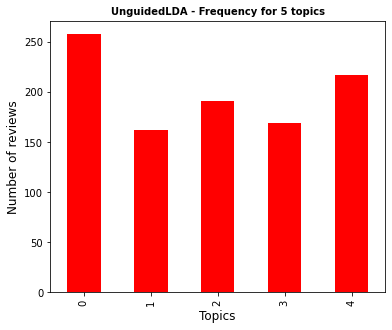

In [39]:
# graph the frequency of topics in the created table 

number_of_topics = frequency_table['Topic'].value_counts().sort_index()
number_of_topics.plot(kind = "bar", color = "red", figsize = (6,5))
plt.title("UnguidedLDA - Frequency for 5 topics", size = 10, fontweight="bold")
plt.xlabel("Topics", size = 12)
plt.ylabel("Number of reviews", size = 12)

For 5 topics, the result is not that bad. The spread of the reviews looks quite balanced accept for the Topic 0. 

Let's try guided LDA to see if we will be able to improve the results or not.

## 4.2 Guided LDA

The imdb_labelled file were reviewed and extracted 5 topics from the file and decided some key words belong to these topics like the following:


- Content: slow-moving, predictable, effor, messages, plot, story, storyline, script, effort, idea, structure, experience

- Quality: art, charm, bad, good,	cool, right, wasted, disappointing, quality, dream, chemistry

- Acting:	acting, character, casting, act, actor, actress, cast, performance, talented, star, leading, convincing, portray

- Genre: thriller, crime,	drama, comedy, cartoon, animation

- Post Production: music, effect, song, photography, composition, editing , effects, graphics


In [40]:
def create_eta(priors, etadict, ntopics):
    eta = np.full(shape=(ntopics, len(etadict)), fill_value=1) # create a (ntopics, nterms) matrix and fill with 1
    for word, topic in priors.items(): # for each word in the list of priors
        keyindex = [index for index,term in etadict.items() if term==word] # look up the word in the dictionary
        if (len(keyindex)>0): # if it's in the dictionary
            eta[topic,keyindex[0]] = 1e7  # put a large number in there
    eta = np.divide(eta, eta.sum(axis=0)) # normalize so that the probabilities sum to 1 over all topics
    return eta

In [41]:
guided_term_topic_dist = {'predictable':0, 'messages':0, 'plot':0 , 'story':0, 'storyline':0, 'script':0, 'effort':0, 'idea':0, 'structure':0, 'experience':0,
                          'art':1, 'charm':1, 'good':1, 'bad':1, 'cool':1, 'right':1, 'wasted':1, 'disappointing':1, 'quality':1, 'dream':1, 'chemistry':1,
                          'acting':2, 'character':2, 'casting':2, 'cast':2, 'act':2, 'actor':2, 'actress':2, 'performance':2, 'talented':2, 'star':2, 'leading':2, 'convincing':2, 'portray':2,
                          'thriller':3, 'crime':3, 'drama':3, 'comedy':3, 'cartoon':3, 'animation':3,
                         'music':4, 'effect':4, 'song':4, 'photography':4, 'composition':4, 'editing':4, 'effects':4, 'graphics':4}

In [42]:
eta = create_eta(guided_term_topic_dist, dictionary, 5)

In [43]:
model2, result2 = test_eta(eta, dictionary, ntopics=5)

Perplexity: 2.63
Topic 0: ['see', 'watch', 'one']
Topic 1: ['bad', 'good', 'even']
Topic 2: ['character', 'know', 'act']
Topic 3: ['really', 'great', 'thing']
Topic 4: ['like', 'time', 'go']
A very, very, very slow-moving, aimless movie about a distressed, drifting young man.  ['(0, 5.1%)', '(1, 4.0%)', '(2, 3.4%)', '(3, 4.1%)', '(4, 83.4%)']
Not sure who was more lost - the flat characters or the audience, nearly half of whom walked out.  ['(0, 4.6%)', '(1, 3.6%)', '(2, 84.0%)', '(3, 3.7%)', '(4, 4.1%)']
Attempting artiness with black & white and clever camera angles, the movie disappointed - became even more ridiculous - as the acting was poor and the plot and lines almost non-existent.  ['(0, 8.3%)', '(1, 6.8%)', '(2, 1.5%)', '(3, 76.3%)', '(4, 7.0%)']
Very little music or anything to speak of.  ['(0, 44.6%)', '(1, 6.0%)', '(2, 5.1%)', '(3, 37.5%)', '(4, 6.8%)']
The best scene in the movie was when Gerardo is trying to find a song that keeps running through his head.  ['(0, 55.4%)',

In [44]:
result2.head()

,ID,Review,Topic,Probability
0,1,"A very, very, very slow-moving, aimless movie ...",0,0.051472
1,2,"A very, very, very slow-moving, aimless movie ...",1,0.039712
2,3,"A very, very, very slow-moving, aimless movie ...",2,0.033546
3,4,"A very, very, very slow-moving, aimless movie ...",3,0.040856
4,5,"A very, very, very slow-moving, aimless movie ...",4,0.834413


In [45]:
# assign the topic for each review by selecting the topic with highest probability
frequency_table_2 = result2.loc[result2.groupby('Review')['Probability'].idxmax()]
frequency_table_2.sort_values('ID', inplace=True)
frequency_table_2

,ID,Review,Topic,Probability
4,5,"A very, very, very slow-moving, aimless movie ...",4,0.834413
7,8,Not sure who was more lost - the flat characte...,2,0.839923
13,14,Attempting artiness with black & white and cle...,3,0.763348
15,16,Very little music or anything to speak of.,0,0.446264
20,21,The best scene in the movie was when Gerardo i...,0,0.554035
...,...,...,...,...
4971,4972,I just got bored watching Jessice Lange take h...,1,0.563570
4976,4977,"Unfortunately, any virtue in this film's produ...",1,0.489770
4984,4985,"In a word, it is embarrassing.",4,0.361579
4986,4987,Exceptionally bad!,1,0.608966


Text(0, 0.5, 'Number of reviews')

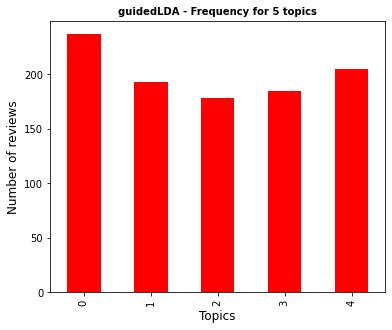

In [46]:
# graph the frequency of topics in the created table 

number_of_topics2 = frequency_table_2['Topic'].value_counts().sort_index()
number_of_topics2.plot(kind = "bar", color = "red", figsize = (6,5))
plt.title("guidedLDA - Frequency for 5 topics", size = 10, fontweight="bold")
plt.xlabel("Topics", size = 12)
plt.ylabel("Number of reviews", size = 12)

As you can see here, the spread of 5 topics improves a bit as the model is able to assign topics across all reviews with the guided LDA.
Unguided LDA was not giving bad results and guided LDA improved the distrubition more.
